# Get Journalist Tweets

In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe

In [2]:
sys.path.insert(1, '../')

In [3]:
from src.data import journalists as journos
from src.data.api_tweepy import connect_API
from src.data import api_tweet_tools as att
from src.data import data_cleanup as dc
from src.topics import hashtag_analysis as ha

In [4]:
keyword = 'cyber'
journo_handles = journos.get_handles_by_keyword(keyword)
print(len(journo_handles))

12


In [8]:
print(journo_handles)

['_lucyingham', 'JesscaHaworth', 'Ad_Nauseum74']


In [6]:
api_keys_fp = '../data/twitter_credentials.json'
tw_api = connect_API(api_keys_fp)

In [7]:
att.batch_request_user_timeline(tw_api, journo_handles, '../data/raw/{}_tweets/'.format(keyword), api_delay=0.2, n_tweets=3200)

User timelines: 100%|████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 15.87s/it]


# Clean Journalist Tweets

In [8]:
src_dir = '../data/raw/{}_tweets/'.format(keyword)
dest_dir = '../data/cleaned/{}_tweets/'.format(keyword)

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]

with tqdm(total=len(files), desc='Files', file=sys.stdout) as pbar:
    for file in files:
        raw_df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        cleaned_df = dc.clean_API_dataframe(raw_df)
        cleaned_df.to_csv(os.path.join(dest_dir, file), index=False)
        pbar.update(1)

Files: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


# Use hashtags to identify topics

In [5]:
src_dir = 'D:/S2DS/Ditchley/Aug20_Ditchley/data/cleaned/{}_tweets/'.format(keyword)

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data = pd.DataFrame()

with tqdm(total=len(files), desc='Files', file=sys.stdout) as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        data = pd.concat([data, df[['screen_name', 'tweet_id', 'text', 'hashtags']]], axis=0, ignore_index=True)
        pbar.update(1)

Files: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


In [6]:
data = data[data['hashtags'].astype(str) != '[]'] # remove empties
data['text'] = data['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
data

screen_name             tweet_id  \
3      jennystrasburg  1298655692623142914   
23     jennystrasburg  1295296427204186113   
77     jennystrasburg  1288463678367510533   
79     jennystrasburg  1288228886774460417   
95     jennystrasburg  1286391864195796994   
...               ...                  ...   
28661    ad_nauseum74  1189939842064539648   
28676    ad_nauseum74  1187760868165144576   
28679    ad_nauseum74  1187727565462618116   
28681    ad_nauseum74  1187645968499597313   
28693    ad_nauseum74  1186674249412599808   

                                                    text  \
3                   it s nationaljealousidonthaveadogday   
23     rt very excited to see today that blood and oi...   
77     rt approximately one fifth of covid patients a...   
79     rt today on thejournal the situation in rural ...   
95     new mexico public defenders prosecutors and ad...   
...                                                  ...   
28661  rt bugbountyradar this month s top bug bounty ...   
28676  rt a ddos gang is impersonating known russian ...   
28679  rt in this week s socialsec roundup breaches a...   
28681  rt hackers are pretty much the same as sharks ...   
28693  rt biometric authentication is not solving the...   

                                  hashtags  
3      ['nationaljealousidonthaveadogday']  
23                         ['bloodandoil']  
77                               ['covid']  
79                          ['thejournal']  
95                         ['albuquerque']  
...                                    ...  
28661                   ['bugbountyradar']  
28676                ['ddos', 'fancybear']  
28679                        ['socialsec']  
28681                   ['hacktivity2019']  
28693      ['dataprivacy', 'datasecurity']  

[3365 rows x 4 columns]

In [7]:
hashtag_observations = ha.vectorize_wordlists(data['hashtags'])
hashtag_observations.info()
hashtag_observations.sparse.density

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3365 entries, 3 to 28693
Columns: 2015 entries, 11amfact to リテールテック
dtypes: Sparse[int64, 0](2015)
memory usage: 80.3 KB


0.0006791559588376919

Sum of the explained variance = 0.399.


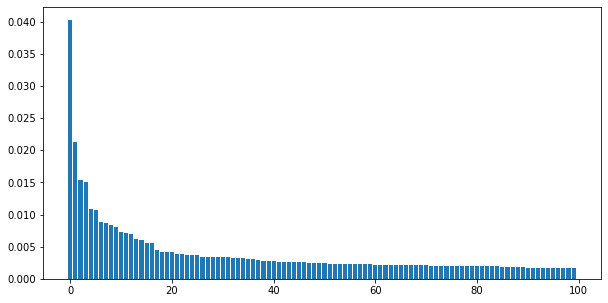

In [8]:
hashtag_dimred, svd_comps = ha.SVD_on_vectors(hashtag_observations, n_components=100)

In [9]:
topics = ha.make_topic_keywords_from_svd(svd_comps, threshold=0.2)
topics.head(50)

keywords
topic                                                   
0                                         [ces, samsung]
1                                       [baselworld2015]
2                           [coronavirus, cybersecurity]
3                                        [cybersecurity]
4                                      [brexit, fintech]
5                              [digitalelection, ge2019]
6                                               [brexit]
7                                        [journorequest]
8                                         [deutschebank]
9                                              [bitcoin]
10                                [facebook, zuckerberg]
11                                    [fortniteworldcup]
12                                             [samsung]
13                                              [ge2019]
14                          [ai, artificialintelligence]
15                                               [spook]
16                                               [bhusa]
17                                               [apple]
18                                              [chcity]
19                                 [scrollfreeseptember]
20                                       [aspensecurity]
21                                            [appseceu]
22     [appseceu, blacklivesmatter, libreplanet2020, ...
23                                             [mifidii]
24                                            [bbcclick]
25                                                [gchq]
26                                            [breaking]
27                   [awssummit, blockchain, futurefest]
28                                           [awssummit]
29                                             [ces2019]
30                                        [5g, lockdown]
31               [blacklivesmatter, covid19, cybercrime]
32                                                [bheu]
33     [covid19, internationalwomensday, libreplanet2...
34                       [libreplanet2020, russiareport]
35                [internationalwomensday, russiareport]
36                                    [may4th, starwars]
37       [business, collisionfromhome, data, mojo, tech]
38                                          [litvinenko]
39     [artificialintelligence, covidー19, gdpr, nhs, ...
40                                                  [lg]
41                                                 [mi5]
42                                                [ff7r]
43                                       [cyberflashing]
44                                  [gdpr, google, uber]
45                           [china, gdpr, russia, uber]
46                [artificialintelligence, google, uber]
47                                      [crypto, london]
48                                          [cybercrime]
49                                          [emceeforum]

In [10]:
data['labels'] = ha.label_data_by_topic(hashtag_dimred, 0.2)
labelled_data = data
labelled_data

screen_name             tweet_id  \
3      jennystrasburg  1298655692623142914   
23     jennystrasburg  1295296427204186113   
77     jennystrasburg  1288463678367510533   
79     jennystrasburg  1288228886774460417   
95     jennystrasburg  1286391864195796994   
...               ...                  ...   
28661    ad_nauseum74  1189939842064539648   
28676    ad_nauseum74  1187760868165144576   
28679    ad_nauseum74  1187727565462618116   
28681    ad_nauseum74  1187645968499597313   
28693    ad_nauseum74  1186674249412599808   

                                                    text  \
3                   it s nationaljealousidonthaveadogday   
23     rt very excited to see today that blood and oi...   
77     rt approximately one fifth of covid patients a...   
79     rt today on thejournal the situation in rural ...   
95     new mexico public defenders prosecutors and ad...   
...                                                  ...   
28661  rt bugbountyradar this month s top bug bounty ...   
28676  rt a ddos gang is impersonating known russian ...   
28679  rt in this week s socialsec roundup breaches a...   
28681  rt hackers are pretty much the same as sharks ...   
28693  rt biometric authentication is not solving the...   

                                  hashtags  labels  
3      ['nationaljealousidonthaveadogday']     NaN  
23                         ['bloodandoil']     NaN  
77                               ['covid']    68.0  
79                          ['thejournal']     NaN  
95                         ['albuquerque']     NaN  
...                                    ...     ...  
28661                   ['bugbountyradar']    94.0  
28676                ['ddos', 'fancybear']     NaN  
28679                        ['socialsec']     NaN  
28681                   ['hacktivity2019']     NaN  
28693      ['dataprivacy', 'datasecurity']     NaN  

[3365 rows x 5 columns]

## Attempt to visualise the topic space

In [11]:
from src import plots

In [12]:
labelled_data[['tsne_x', 'tsne_y']] = plots.make_tSNE_projection_of_SVD(hashtag_dimred, kwargs=dict(n_jobs=7, n_iter=1000))

In [13]:
labelled_data

screen_name             tweet_id  \
3      jennystrasburg  1298655692623142914   
23     jennystrasburg  1295296427204186113   
77     jennystrasburg  1288463678367510533   
79     jennystrasburg  1288228886774460417   
95     jennystrasburg  1286391864195796994   
...               ...                  ...   
28661    ad_nauseum74  1189939842064539648   
28676    ad_nauseum74  1187760868165144576   
28679    ad_nauseum74  1187727565462618116   
28681    ad_nauseum74  1187645968499597313   
28693    ad_nauseum74  1186674249412599808   

                                                    text  \
3                   it s nationaljealousidonthaveadogday   
23     rt very excited to see today that blood and oi...   
77     rt approximately one fifth of covid patients a...   
79     rt today on thejournal the situation in rural ...   
95     new mexico public defenders prosecutors and ad...   
...                                                  ...   
28661  rt bugbountyradar this month s top bug bounty ...   
28676  rt a ddos gang is impersonating known russian ...   
28679  rt in this week s socialsec roundup breaches a...   
28681  rt hackers are pretty much the same as sharks ...   
28693  rt biometric authentication is not solving the...   

                                  hashtags  labels     tsne_x     tsne_y  
3      ['nationaljealousidonthaveadogday']     NaN  23.635946   3.235146  
23                         ['bloodandoil']     NaN  26.105919   2.928270  
77                               ['covid']    68.0  -9.305646 -27.358776  
79                          ['thejournal']     NaN -35.935352 -12.195557  
95                         ['albuquerque']     NaN   8.423697 -14.477675  
...                                    ...     ...        ...        ...  
28661                   ['bugbountyradar']    94.0 -53.563107 -11.583477  
28676                ['ddos', 'fancybear']     NaN -23.566561   5.056479  
28679                        ['socialsec']     NaN -24.759132 -21.282015  
28681                   ['hacktivity2019']     NaN  27.561855   7.879110  
28693      ['dataprivacy', 'datasecurity']     NaN  -5.804718 -10.591902  

[3365 rows x 7 columns]

In [14]:
viz = labelled_data.dropna()
viz['labels'] = viz['labels'].astype(int)
viz.loc[:,'labels_str'] = viz.loc[:,'labels'].astype(str)
viz

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

screen_name             tweet_id  \
77     jennystrasburg  1288463678367510533   
119    jennystrasburg  1283782639015559175   
178    jennystrasburg  1278645139011973120   
189    jennystrasburg  1278217674724605952   
277    jennystrasburg  1288463678367510533   
...               ...                  ...   
28634    ad_nauseum74  1202164001918070785   
28635    ad_nauseum74  1202163931134996480   
28637    ad_nauseum74  1202150273516478465   
28659    ad_nauseum74  1191653702928601088   
28661    ad_nauseum74  1189939842064539648   

                                                    text  \
77     rt approximately one fifth of covid patients a...   
119    rt lost decade how bafin for years played down...   
178    rt germany said it would disband part of its e...   
189    rt breaking a man was arrested for holding a h...   
277    rt approximately one fifth of covid patients a...   
...                                                  ...   
28634  rt facebook s amanda rousseau opens bheu by re...   
28635  rt are you ready for bheu earlier this year we...   
28637  my second ever bheu starting shortly and first...   
28659  rt chinese hackers claim to be able to beat an...   
28661  rt bugbountyradar this month s top bug bounty ...   

                                            hashtags  labels     tsne_x  \
77                                         ['covid']      68  -9.305646   
119                            ['bafin', 'wirecard']      71 -15.149402   
178                                      ['germany']      68 -44.153809   
189    ['breaking', 'hkindependence', 'causewaybay']      26  15.497751   
277                                        ['covid']      68  -9.305753   
...                                              ...     ...        ...   
28634                                       ['bheu']      32   6.339704   
28635                                       ['bheu']      32   5.874580   
28637                                       ['bheu']      32   5.234831   
28659                                    ['infosec']      82 -52.550236   
28661                             ['bugbountyradar']      94 -53.563107   

          tsne_y labels_str  
77    -27.358776         68  
119     4.195018         71  
178   -20.471458         68  
189   -34.216160         26  
277   -27.358927         68  
...          ...        ...  
28634  20.037624         32  
28635  19.431202         32  
28637  19.935366         32  
28659   1.435778         82  
28661 -11.583477         94  

[1640 rows x 8 columns]

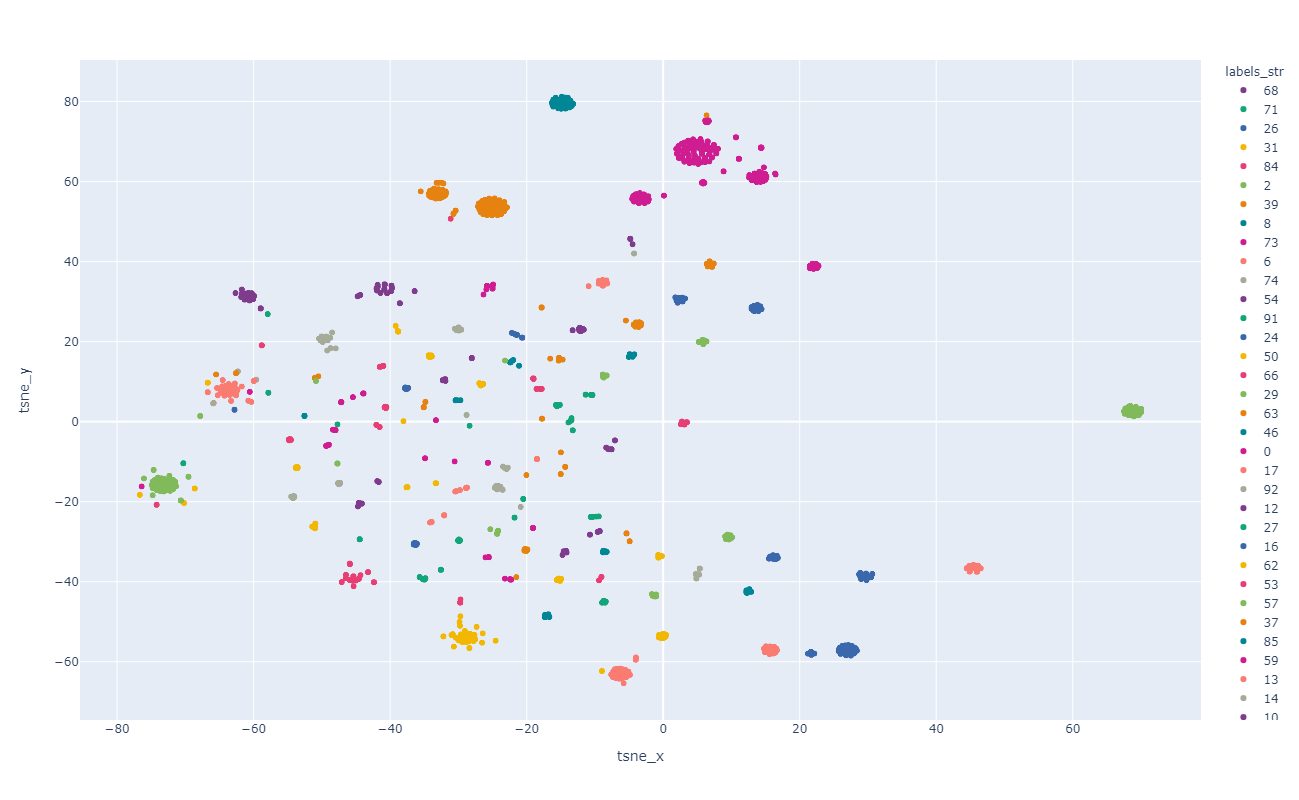

In [15]:
plots.plot_tsne_projection(viz, 'labels_str', plotly=True, kwargs=dict(hover_name='screen_name', hover_data=['hashtags']))

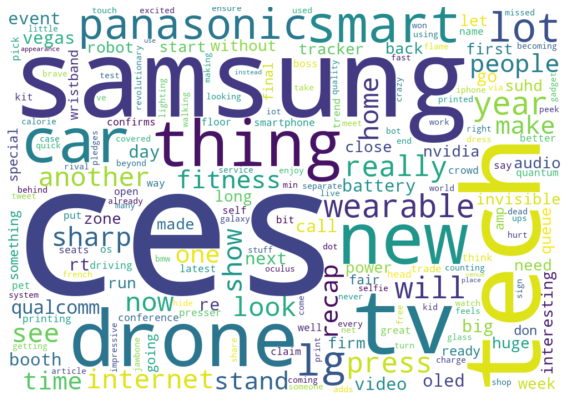

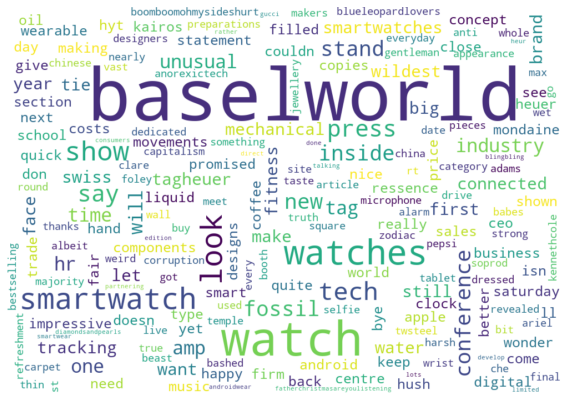

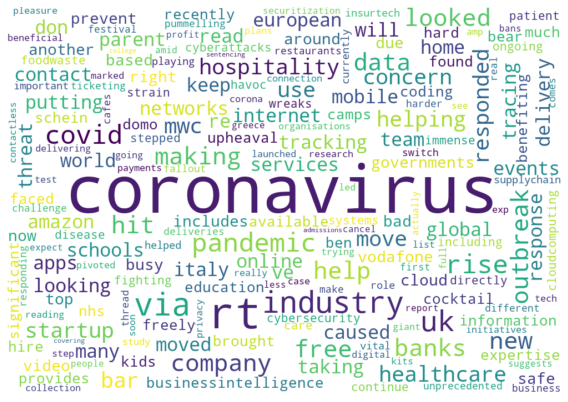

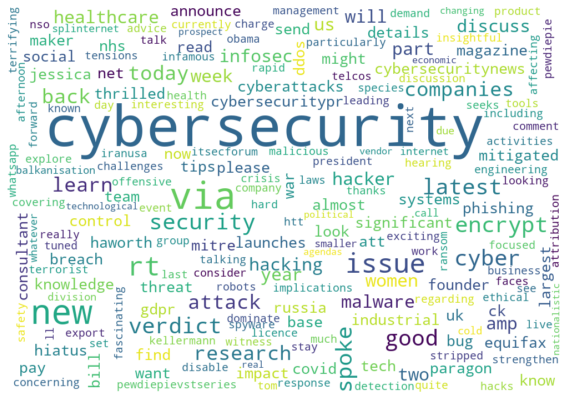

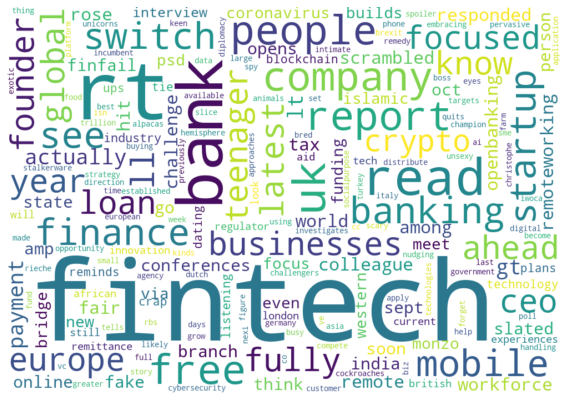

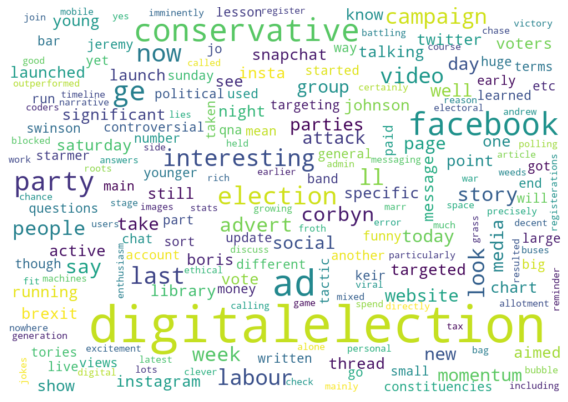

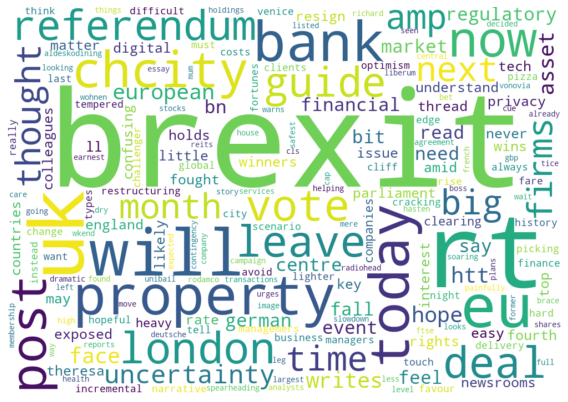

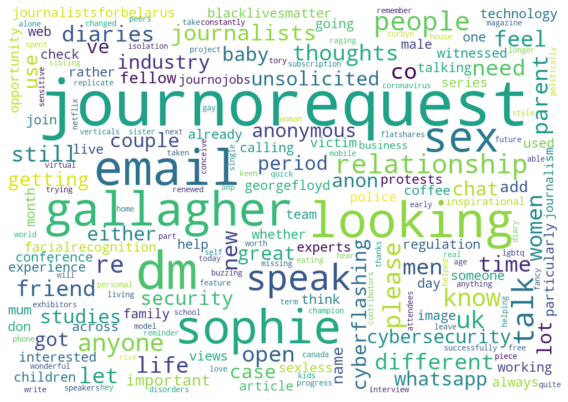

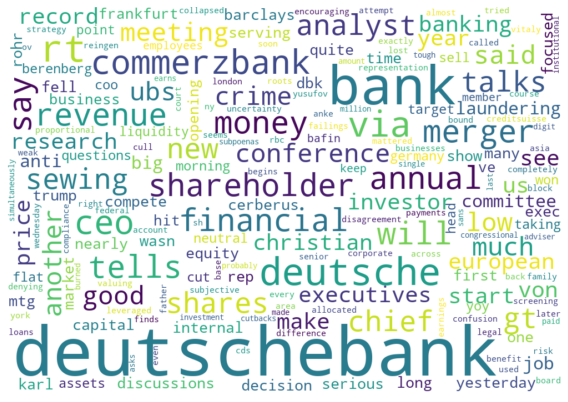

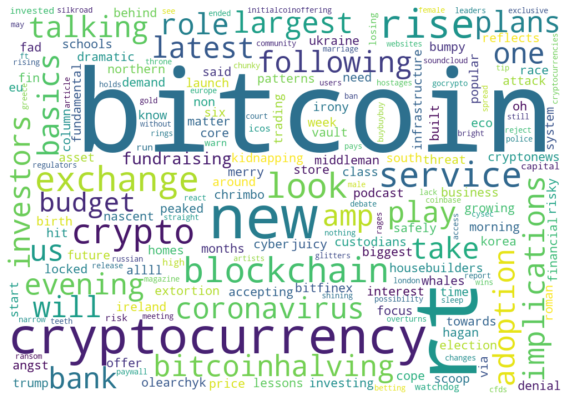

In [18]:
subset = viz[viz['labels']<10]
outs = subset.groupby('labels')['text'].apply(lambda x: plots.wordcloud_plot(' '.join(x)))

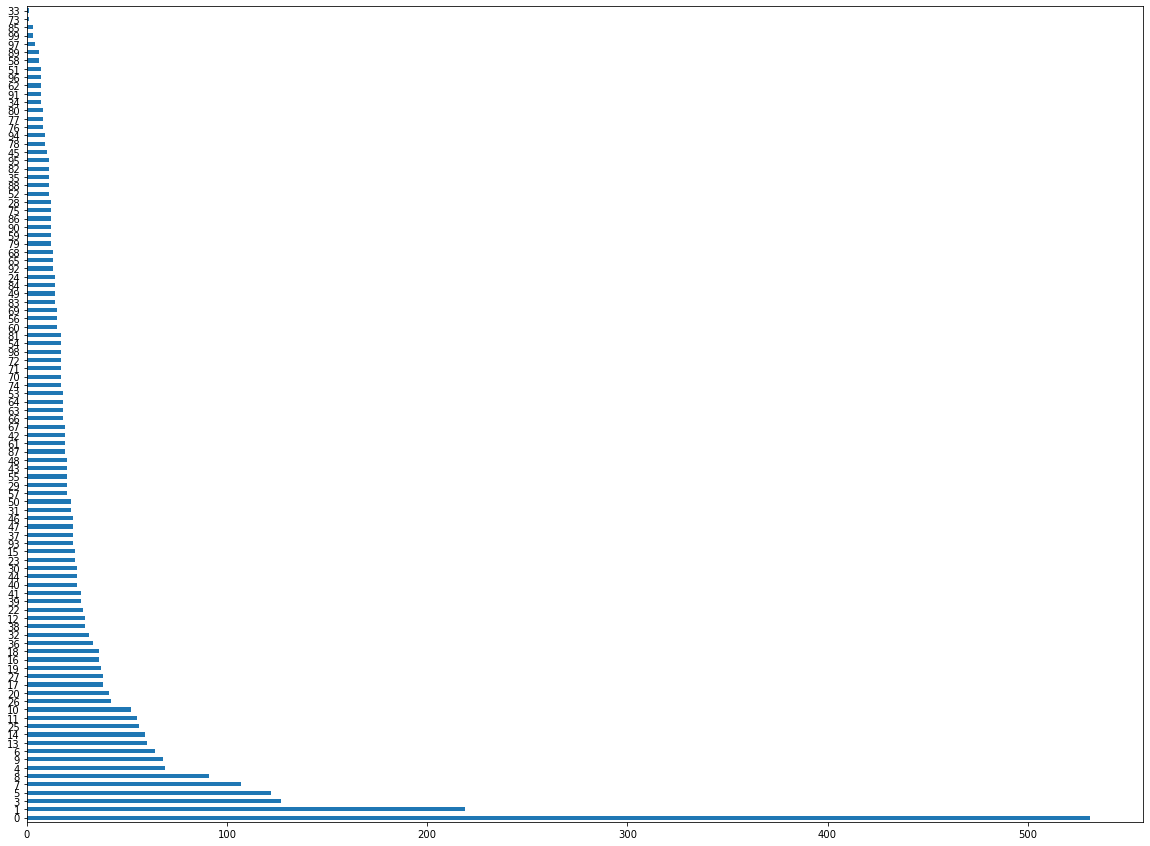

In [21]:
viz['labels'].value_counts().plot.barh()
fig = plt.gcf()
fig.set_size_inches(20,15)
#plt.xscale('log')
plt.show()

In [23]:
labelled_data.to_csv('../data/cleaned/labelled_{}_journo_tweets.csv'.format(keyword), index=False)
topics.to_csv('../data/cleaned/{}_journo_topic_labels.csv'.format(keyword), index=True)

In [24]:
viz.groupby('labels')['screen_name'].unique()

labels
0     [johnnyarhb, jeremylawhodges, rokav, yannicrac...
1                         [johnnyarhb, camillanaschert]
10                 [johnnyarhb, rokav, camillanaschert]
11    [johnnyarhb, jeremylawhodges, kosullivanit, ro...
12                        [johnnyarhb, camillanaschert]
                            ...                        
95      [johnnyarhb, rokav, yannicrack, alexblackburne]
96                        [johnnyarhb, camillanaschert]
97                        [johnnyarhb, camillanaschert]
98           [johnnyarhb, kosullivanit, alexblackburne]
99               [kosullivanit, rokav, camillanaschert]
Name: screen_name, Length: 98, dtype: object

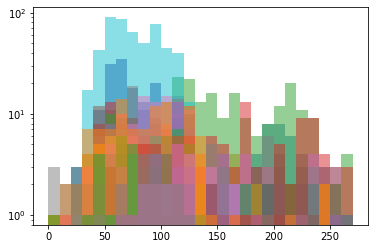

In [25]:
plt.figure()
for label in viz.labels.unique():
    plt.hist(viz.loc[viz['labels']==label, 'text'].str.len(), bins=range(0,280,10), alpha=0.5, label=label)
plt.yscale('log')

In [34]:
viz[viz['labels']==label]

screen_name             tweet_id  \
28038  jesscahaworth  1017366486107779072   
28041  jesscahaworth  1016696585357492225   
28044  jesscahaworth  1015243627365269505   
28047  jesscahaworth  1015229333009559552   
28048  jesscahaworth  1015223845320642560   
28051  jesscahaworth  1015147021550972928   
28052  jesscahaworth  1015142882263609344   
28054  jesscahaworth  1014884718955958278   
28055  jesscahaworth  1014861892421111808   
28056  jesscahaworth  1014857313046409216   
28057  jesscahaworth  1014854676838264832   
28058  jesscahaworth  1014850980456919040   
28059  jesscahaworth  1014850723190894592   
28060  jesscahaworth  1014849772916748288   
28062  jesscahaworth  1014784226422677505   
28063  jesscahaworth  1014782638547259392   
28064  jesscahaworth  1014781660859191296   
28065  jesscahaworth  1014776196826050561   

                                                    text  \
28038  dressed in black fading into the background an...   
28041  a lack of cybersecurity staff is increasing re...   
28044  i spoke to about his new hackability inspector...   
28047  security developers and ops need to work toget...   
28048  here is speaking about how security is everyon...   
28051  and here mario is check his cool hawaiian shir...   
28052  i m back for the final day of appseceu current...   
28054  listening to discussing his postmessage extens...   
28055  packed out talk by research director on how le...   
28056      found my spirit animal in this slide appseceu   
28057  knobloch explains how important integration is...   
28058  too many companies are employing the same peop...   
28059  martin knobloch talking about the need for div...   
28060  owasp chairman martin knobloch is here talking...   
28062  apologies missed the line before weidman is ta...   
28063  here is reminding me that i really need to bri...   
28064  keynote speaker is on stage she opens by prais...   
28065  i m at appseceu for the next two days tweeting...   

                            hashtags labels     tsne_x     tsne_y  
28038                   ['appseceu']     21   1.556473  48.411171  
28041                   ['appseceu']     21   3.029343  47.002609  
28044                   ['appseceu']     21   1.556473  48.411171  
28047                   ['appseceu']     21   1.683188  47.050873  
28048                   ['appseceu']     21   3.298215  48.526077  
28051                   ['appseceu']     21   3.298215  48.526077  
28052                   ['appseceu']     21   3.298215  48.526077  
28054                   ['appseceu']     21   2.265792  49.707600  
28055                   ['appseceu']     21   3.298215  48.526077  
28056                   ['appseceu']     21   3.298215  48.526077  
28057                   ['appseceu']     21   3.029343  47.002609  
28058                   ['appseceu']     21   1.556473  48.411171  
28059                   ['appseceu']     21   3.298215  48.526077  
28060                   ['appseceu']     21   2.265792  49.707600  
28062                   ['appseceu']     21   1.556473  48.411171  
28063                   ['appseceu']     21   3.029343  47.002609  
28064                   ['appseceu']     21   1.683188  47.050873  
28065  ['appseceu', 'cybersecurity']     21 -98.526497  19.678583

In [26]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [27]:
viz['tokens'] = viz['text'].apply(lambda x: nltk.word_tokenize(x))

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
viz

screen_name             tweet_id  \
0           johnnyarhb  1299299290469281792   
1           johnnyarhb  1294206562916073479   
2           johnnyarhb  1293178568202100741   
4           johnnyarhb  1291718463703199745   
5           johnnyarhb  1290668182102056966   
...                ...                  ...   
17453  camillanaschert   752840629047164928   
17454  camillanaschert   752499375444746240   
17457  camillanaschert   752425565676793856   
17466  camillanaschert   746344034872983553   
17523  camillanaschert   715308670897233921   

                                                    text  \
0      worth a listen discussing the bio marine fuels...   
1      rt us independent refiner plans to convert its...   
2      free to read the uk will transpose the eu coun...   
4      rt participants in the waste grade biodiesel s...   
5      free to read change in france s fame c biodies...   
...                                                  ...   
17453        b rse frankfurt dax lag nur kurz ber punkte   
17454  rt u k s ftse defies brexit blues to head for ...   
17457  rt wissen sie noch die junge lassen sich v alt...   
17466  rt the s free brexit extra tabloid hot off the...   
17523  rt mount trumpmore die usa machen sich bereit ...   

                                         hashtags labels     tsne_x  \
0                               ['argusbiofuels']      6 -39.437996   
1                       ['refining', 'renewable']     66 -20.411131   
2                  ['biodiesel', 'argusbiofuels']      1 -43.657543   
4                                   ['biodiesel']      1 -69.412529   
5      ['biodiesel', 'rapeseed', 'argusbiofuels']      1 -41.175510   
...                                           ...    ...        ...   
17453     ['börse', 'frankfurt', 'dax', 'punkte']     78  18.909401   
17454                                  ['brexit']     14   7.022405   
17457                                  ['brexit']     14   6.929500   
17466                        ['brexit', 'london']     14   6.864855   
17523                                   ['trump']     39 -35.766495   

           tsne_y                                             tokens  
0      -47.596889  [worth, a, listen, discussing, the, bio, marin...  
1       -2.574088  [rt, us, independent, refiner, plans, to, conv...  
2      -69.982338  [free, to, read, the, uk, will, transpose, the...  
4      -80.641403  [rt, participants, in, the, waste, grade, biod...  
5      -66.350121  [free, to, read, change, in, france, s, fame, ...  
...           ...                                                ...  
17453   -0.571034  [b, rse, frankfurt, dax, lag, nur, kurz, ber, ...  
17454  101.854164  [rt, u, k, s, ftse, defies, brexit, blues, to,...  
17457   98.780785  [rt, wissen, sie, noch, die, junge, lassen, si...  
17466  103.893875  [rt, the, s, free, brexit, extra, tabloid, hot...  
17523   -9.938013  [rt, mount, trumpmore, die, usa, machen, sich,...  

[3156 rows x 8 columns]

In [29]:
viz['lemmatized'] = viz['tokens'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
viz['lemmatized'] = viz['lemmatized'].apply(lambda x: [word for word in x if not word in stop_words])
viz['lemmatized'] = viz['lemmatized'].apply(lambda x: [word for word in x if not word == 'rt'])

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
viz

screen_name             tweet_id  \
0           johnnyarhb  1299299290469281792   
1           johnnyarhb  1294206562916073479   
2           johnnyarhb  1293178568202100741   
4           johnnyarhb  1291718463703199745   
5           johnnyarhb  1290668182102056966   
...                ...                  ...   
17453  camillanaschert   752840629047164928   
17454  camillanaschert   752499375444746240   
17457  camillanaschert   752425565676793856   
17466  camillanaschert   746344034872983553   
17523  camillanaschert   715308670897233921   

                                                    text  \
0      worth a listen discussing the bio marine fuels...   
1      rt us independent refiner plans to convert its...   
2      free to read the uk will transpose the eu coun...   
4      rt participants in the waste grade biodiesel s...   
5      free to read change in france s fame c biodies...   
...                                                  ...   
17453        b rse frankfurt dax lag nur kurz ber punkte   
17454  rt u k s ftse defies brexit blues to head for ...   
17457  rt wissen sie noch die junge lassen sich v alt...   
17466  rt the s free brexit extra tabloid hot off the...   
17523  rt mount trumpmore die usa machen sich bereit ...   

                                         hashtags labels     tsne_x  \
0                               ['argusbiofuels']      6 -39.437996   
1                       ['refining', 'renewable']     66 -20.411131   
2                  ['biodiesel', 'argusbiofuels']      1 -43.657543   
4                                   ['biodiesel']      1 -69.412529   
5      ['biodiesel', 'rapeseed', 'argusbiofuels']      1 -41.175510   
...                                           ...    ...        ...   
17453     ['börse', 'frankfurt', 'dax', 'punkte']     78  18.909401   
17454                                  ['brexit']     14   7.022405   
17457                                  ['brexit']     14   6.929500   
17466                        ['brexit', 'london']     14   6.864855   
17523                                   ['trump']     39 -35.766495   

           tsne_y                                             tokens  \
0      -47.596889  [worth, a, listen, discussing, the, bio, marin...   
1       -2.574088  [rt, us, independent, refiner, plans, to, conv...   
2      -69.982338  [free, to, read, the, uk, will, transpose, the...   
4      -80.641403  [rt, participants, in, the, waste, grade, biod...   
5      -66.350121  [free, to, read, change, in, france, s, fame, ...   
...           ...                                                ...   
17453   -0.571034  [b, rse, frankfurt, dax, lag, nur, kurz, ber, ...   
17454  101.854164  [rt, u, k, s, ftse, defies, brexit, blues, to,...   
17457   98.780785  [rt, wissen, sie, noch, die, junge, lassen, si...   
17466  103.893875  [rt, the, s, free, brexit, extra, tabloid, hot...   
17523   -9.938013  [rt, mount, trumpmore, die, usa, machen, sich,...   

                                              lemmatized  
0      [worth, listen, discussing, bio, marine, fuel,...  
1      [u, independent, refiner, plan, convert, san, ...  
2      [free, read, uk, transpose, eu, countervailing...  
4      [participant, waste, grade, biodiesel, sector,...  
5      [free, read, change, france, fame, c, biodiese...  
...                                                  ...  
17453  [b, rse, frankfurt, dax, lag, nur, kurz, ber, ...  
17454  [u, k, ftse, defies, brexit, blue, head, bull,...  
17457  [wissen, sie, noch, die, junge, lassen, sich, ...  
17466  [free, brexit, extra, tabloid, hot, press, dis...  
17523  [mount, trumpmore, die, usa, machen, sich, ber...  

[3156 rows x 9 columns]

In [32]:
import gensim

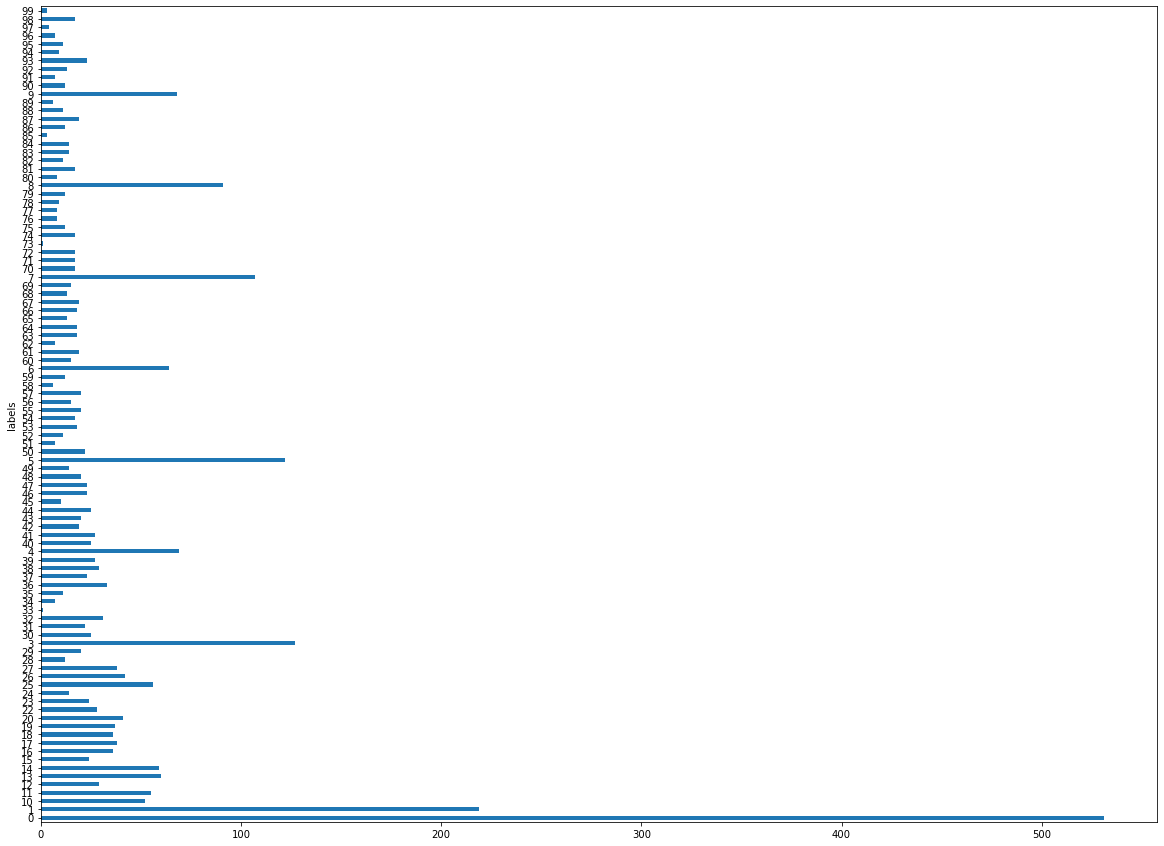

In [33]:
viz.groupby('labels')['lemmatized'].apply(len).plot.barh()
fig = plt.gcf()
fig.set_size_inches(20,15)
#plt.xscale('log')
plt.show()

In [34]:
data4w2v = viz
data4w2v.labels.unique()

array(['6', '66', '1', '3', '35', '56', '10', '11', '31', '0', '51', '49',
       '91', '42', '24', '17', '14', '97', '28', '85', '5', '16', '79',
       '27', '15', '19', '77', '4', '75', '93', '82', '76', '34', '40',
       '23', '9', '22', '72', '12', '29', '80', '39', '18', '95', '30',
       '53', '37', '64', '38', '96', '13', '50', '52', '62', '65', '45',
       '8', '25', '98', '55', '59', '41', '84', '69', '26', '32', '36',
       '54', '73', '88', '44', '86', '83', '43', '81', '67', '90', '99',
       '48', '60', '89', '78', '20', '94', '33', '71', '74', '46', '58',
       '47', '68', '7', '57', '87', '92', '61', '70', '63'], dtype=object)

In [35]:
%%time
size = 100

model_w2v = gensim.models.Word2Vec(
            data4w2v.lemmatized,
            size=size, # desired no. of features/independent variables
            window=5, # context window size
            min_count=1, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 4, # no.of cores
            seed = 34
)

model_w2v.train(data4w2v.lemmatized, total_examples= len(data4w2v.lemmatized), epochs=30)

Wall time: 5.65 s


(1016117, 1103610)

In [37]:
model_w2v.wv.most_similar(positive="oil")

[('substantial', 0.6276527643203735),
 ('renaissance', 0.6271170377731323),
 ('firmer', 0.6267596483230591),
 ('painful', 0.6263929605484009),
 ('middleeast', 0.6180403828620911),
 ('bakken', 0.6061305999755859),
 ('joining', 0.6040589809417725),
 ('suffer', 0.603438138961792),
 ('dismisses', 0.6023843288421631),
 ('sideline', 0.6022306680679321)]

In [38]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [39]:
wordvec_arrays = np.zeros((len(data4w2v.lemmatized), size)) 
for i in range(len(data4w2v.lemmatized)):
    wordvec_arrays[i,:] = word_vector(data4w2v.lemmatized.iloc[i], size)
wordvec_df = pd.DataFrame(wordvec_arrays, index=data4w2v.index)
wordvec_df.shape

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(3156, 100)

In [40]:
wordvec_df

0         1         2         3         4         5         6   \
0     -0.508057 -0.342198 -0.169316 -0.127060  0.507314 -0.258414  0.008818   
1     -0.565538 -0.332799 -0.023366  0.384072  0.656689 -0.104369  0.312449   
2     -0.829188 -0.369167  0.061723  0.235916  0.494695  0.023725 -0.050240   
4     -0.456473 -0.325175 -0.043584  0.356623  0.732827 -0.129102 -0.218209   
5     -0.639555 -0.514444  0.108007  0.416802  0.720133  0.042749  0.050895   
...         ...       ...       ...       ...       ...       ...       ...   
17453 -0.257579 -0.418012 -0.007193 -0.103948  0.123028 -0.160586  0.243129   
17454 -0.569615 -0.651848 -0.060883  0.221494  0.575014  0.135761  0.458883   
17457 -0.155442 -0.237373  0.002852  0.070050  0.333204 -0.115678  0.242460   
17466 -0.385657 -0.419396 -0.077483  0.294247  0.734848 -0.032261  0.236519   
17523 -0.182622 -0.290649  0.051109 -0.035198  0.460256 -0.019248  0.120443   

             7         8         9   ...        90        91        92  \
0      0.167394 -0.098755 -0.302336  ... -0.089018  0.113695 -0.382660   
1      0.587620 -0.146553 -0.272360  ...  0.042157 -0.175467 -0.045776   
2      0.250515 -0.223893 -0.660863  ...  0.009665  0.152638 -0.273123   
4      0.352290 -0.070350 -0.251210  ...  0.246533  0.120773 -0.352190   
5      0.534213 -0.210919 -0.464845  ...  0.014023  0.315149 -0.279635   
...         ...       ...       ...  ...       ...       ...       ...   
17453  0.691209  0.169102  0.047968  ...  0.155211 -0.133688  0.095777   
17454  0.518188  0.164313 -0.078396  ... -0.093947  0.057195 -0.148681   
17457  0.450332  0.020438  0.021951  ...  0.110938  0.016122 -0.002376   
17466  0.587271 -0.172357 -0.406941  ...  0.117039  0.353311  0.161413   
17523  0.422149 -0.184205  0.054421  ...  0.075582  0.097407  0.054415   

             93        94        95        96        97        98        99  
0     -0.139449 -0.048538 -0.309569  0.493128  0.213276 -0.419400  0.082583  
1     -0.296523  0.318330 -0.136688  0.050448  0.017713 -0.376135 -0.051369  
2     -0.152665  0.331532 -0.176744  0.396920  0.468626 -0.199495  0.196990  
4     -0.143091 -0.106933 -0.256829  0.169839  0.311880 -0.249264  0.007062  
5     -0.192510  0.198570  0.045519  0.132601  0.351863 -0.265807  0.238819  
...         ...       ...       ...       ...       ...       ...       ...  
17453 -0.190973  0.122435 -0.202570 -0.053674  0.203695 -0.072825  0.345405  
17454 -0.533612  0.258357  0.168578  0.324434 -0.154208  0.214903  0.222563  
17457 -0.310138  0.295579 -0.071082  0.194496  0.068413  0.019316  0.343552  
17466 -0.546400  0.099310  0.131674  0.157646  0.022839 -0.029005  0.272937  
17523 -0.232436  0.290905 -0.185963  0.150870 -0.020336 -0.149233  0.113056  

[3156 rows x 100 columns]

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data4w2v, data4w2v['labels'].astype(str), random_state=42, test_size=0.5)

In [43]:
train_w2v = wordvec_df.loc[ytrain.index]
test_w2v = wordvec_df.loc[yvalid.index]

#xtrain_w2v = train_w2v.loc[ytrain.index,:]
#xvalid_w2v = train_w2v.loc[yvalid.index,:]

lreg = LogisticRegression(solver='lbfgs', n_jobs=6, C=1e5, max_iter=1000) 
lreg.fit(train_w2v, ytrain) 
ypred = lreg.predict(test_w2v)

#gbc = GradientBoostingClassifier()
#gbc.fit(train_w2v, ytrain)
#ypred = gbc.predict(test_w2v)

print('Testing accuracy %s' % accuracy_score(yvalid, ypred))
print('Testing precision %s' % precision_score(yvalid, ypred, average='weighted'))
print('Testing recall %s' % recall_score(yvalid, ypred, average='weighted'))
print('Testing F1 score: {}'.format(f1_score(yvalid, ypred, average='weighted')))

Testing accuracy 0.6749049429657795
Testing precision 0.6758254824326364
Testing recall 0.6749049429657795
Testing F1 score: 0.6630376121320335


C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [190]:
scores = lreg.predict_proba(test_w2v)

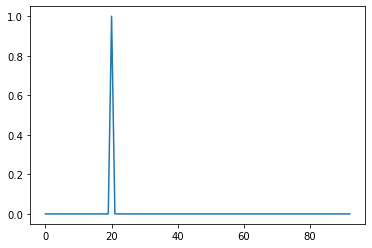

In [194]:
plt.plot(scores[0])

In [202]:
topics.loc[28]

keywords    [awssummit]
Name: 28, dtype: object

In [206]:
xvalid.text.iloc[0]

'i am a true believer that the days of using our keyboard and mouse are over werner vogels amazon cto on the future growth of voice interaction technology awssummit'

In [207]:
ypred

array(['28', '43', '80', '36', '5', '11', '71', '8', '22', '35', '7', '4',
       '20', '22', '1', '2', '9', '1', '1', '2', '13', '9', '17', '3',
       '4', '22', '43', '10', '3', '37', '14', '16', '27', '18', '24',
       '17', '56', '36', '6', '23', '1', '55', '1', '50', '9', '45', '10',
       '29', '29', '16', '23', '91', '13', '1', '50', '81', '8', '6',
       '84', '98', '36', '5', '1', '29', '9', '76', '18', '6', '42', '10',
       '25', '4', '1', '9', '30', '78', '11', '8', '8', '81', '78', '63',
       '4', '31', '29', '62', '64', '75', '86', '17', '65', '1', '22',
       '50', '4', '64', '59', '7', '31', '48', '95', '66', '2', '4', '56',
       '32', '30', '2', '84', '63', '21', '51', '7', '74', '47', '3',
       '22', '20', '41', '16', '1', '38', '10', '25', '37', '6', '80',
       '71', '73', '66', '38', '49', '26', '2', '11', '68', '8', '7', '6',
       '2', '55', '46', '1', '18', '3', '10', '71', '62', '28', '36',
       '24', '31', '10', '28', '41', '59', '35', '32', '3

In [209]:
yvalid.values

array(['28', '43', '52', '36', '5', '11', '71', '8', '51', '35', '7', '4',
       '20', '22', '1', '2', '9', '71', '1', '2', '42', '98', '17', '3',
       '61', '22', '43', '10', '3', '58', '14', '16', '18', '18', '24',
       '93', '68', '36', '18', '25', '1', '55', '1', '50', '9', '45',
       '10', '79', '57', '16', '68', '55', '13', '1', '50', '72', '8',
       '23', '78', '78', '7', '5', '70', '57', '9', '70', '18', '6', '42',
       '10', '3', '4', '1', '9', '30', '78', '11', '8', '8', '25', '49',
       '37', '4', '2', '12', '17', '11', '19', '83', '17', '65', '1',
       '22', '50', '4', '11', '59', '7', '31', '48', '95', '66', '2',
       '61', '4', '32', '30', '51', '45', '36', '86', '51', '5', '81',
       '76', '3', '22', '20', '41', '16', '1', '38', '44', '25', '37',
       '6', '80', '71', '4', '5', '38', '49', '26', '2', '11', '68', '8',
       '7', '6', '7', '55', '46', '1', '78', '3', '77', '71', '89', '28',
       '36', '24', '96', '3', '28', '97', '46', '43', '32', '